In [1]:
import os, io
from pathlib import Path
import math
from collections import defaultdict, Counter, deque
from heapq import heapify, heappush, heappop
from itertools import chain
from dataclasses import dataclass, field
import itertools
import sqlite3
import logging
import logging.handlers
import multiprocessing as mp

from tqdm.notebook import tqdm
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance

import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import preprocessing
from scipy.interpolate import RegularGridInterpolator

from utils import *
from hdc import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_1024'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

hdc = Hdc(config.hdc_n, np)

xp = numpy


In [3]:
def ensure_dataset_folder():
    if not os.path.exists(config.dataset_path):
        print(f'Creating "{config.dataset_path}"')
        os.mkdir(config.dataset_path)

def is_table_exists(db_con, table_name):
    df = pd.read_sql('SELECT name FROM sqlite_master WHERE type=:type AND name=:table_name', params={'type': 'table', 'table_name': table_name}, con=db_con)
    return len(df) > 0

def is_table_empty(db_con, table_name):
    cur = train_db_con.cursor() 
    return len(cur.execute(f'SELECT * FROM {table_name} LIMIT 1').fetchall()) < 1

def drop_table_safe(db_con, tn):
    if is_table_exists(db_con, tn):
        db_con.cursor().execute(f'DROP TABLE {tn}')
        db_con.commit()

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

ensure_dataset_folder()
hdv_db_con = sqlite3.connect(get_full_db_file_name(config.hdv_db_file_name), autocommit=False)
train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name), autocommit=False)
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name), autocommit=False)

# Load MNIST

In [4]:
dataset_source = os.path.join(config.dataset_source)

In [5]:
import struct
from array import array

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        
        images = []
        
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images.append(img)
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

CPU times: user 215 ms, sys: 79.6 ms, total: 294 ms
Wall time: 292 ms


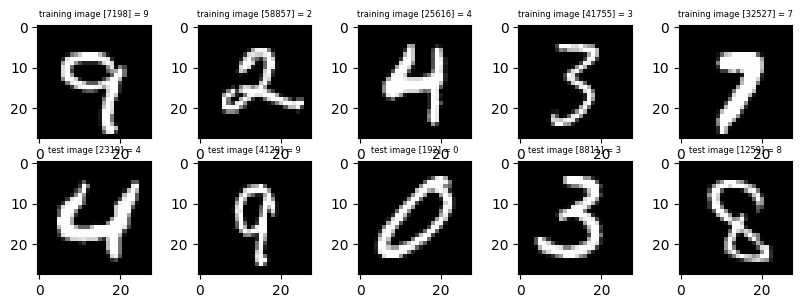

In [6]:
%%time
import random

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = os.path.join(dataset_source, 'train-images-idx3-ubyte')
training_labels_filepath = os.path.join(dataset_source, 'train-labels-idx1-ubyte')
test_images_filepath = os.path.join(dataset_source, 't10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(dataset_source, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,5))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 6);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# Sensor

In [7]:
SENSOR_RECEPTIVE_FIELD_SIZE = 8
SENSOR_RECEPTIVE_FIELD_SQUARE = SENSOR_RECEPTIVE_FIELD_SIZE ** 2

SENSORS_COUNT = config.sensors_count
SENSORS_COUNT_ROOT = int(np.sqrt(SENSORS_COUNT))
assert SENSORS_COUNT_ROOT ** 2 == SENSORS_COUNT
assert SENSORS_COUNT_ROOT > 1


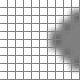
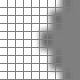
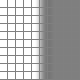
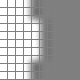
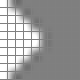
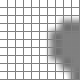
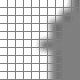
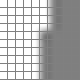
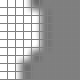
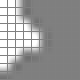
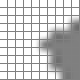
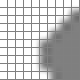
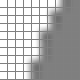
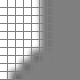
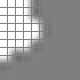
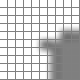
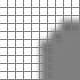
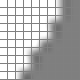
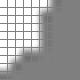
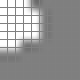

In [8]:
SENSOR_STATES_INFO = defaultdict(list)
SENSOR_STATES_IMG = []
sz = SENSOR_RECEPTIVE_FIELD_SIZE
captions = []

assert config.encoding_type == 'sequence'

angle_step = 10 # degrees
angles = list(range(0, 360, angle_step)) + [45 * 1, 45 * 3, 45 * 5, 45 * 7]
angles = sorted(angles)
# sweeps = [50, 90, 130, 180, 230, 270, 310] # for receptive field size = 8 more finer sweeps make little sense 
sweeps = [90, 130, 180, 230, 270] # for receptive field size = 8 more finer sweeps make little sense 

for angle in angles:
    # for sweep in range(angle_step, 180 + angle_step, angle_step):
    for sweep in sweeps:
        canvas = Image.new('L', (sz, sz))
        draw = ImageDraw.Draw(canvas)
        draw.rectangle([0, 0, sz, sz], fill=127, outline=127)
        piesclice_angle1 = angle + sweep // 2
        piesclice_angle2 = angle - sweep // 2
        draw.pieslice([-sz, -sz, sz * 2 - 1, sz * 2 - 1], start=piesclice_angle1, end=piesclice_angle2, fill=255, outline=255, width=0)
        captions.append(f'ang={angle}, swp={sweep} ')
        SENSOR_STATES_IMG.append(canvas)
        SENSOR_STATES_INFO['normal'].append(angle)
        SENSOR_STATES_INFO['sweep'].append(sweep)
        SENSOR_STATES_INFO['normal_vec'].append(np.exp((1j) * np.radians(angle)))
        SENSOR_STATES_INFO['sweep1_vec'].append(np.exp((1j) * np.radians(piesclice_angle1)))
        SENSOR_STATES_INFO['sweep2_vec'].append(np.exp((1j) * np.radians(piesclice_angle2)))

SENSOR_STATES_INFO = pd.DataFrame(SENSOR_STATES_INFO)
assert len(SENSOR_STATES_INFO) == len(SENSOR_STATES_IMG)
n_to_show = len(sweeps) * 4
images_to_show = list(map(lambda x: lay_grid(x.resize((80, 80)), 8), SENSOR_STATES_IMG[:n_to_show]))
display_images_grid(images_to_show, captions=captions[:n_to_show], col_count=len(sweeps) )

In [9]:
SENSOR_STATES_INFO.head()

,normal,sweep,normal_vec,sweep1_vec,sweep2_vec
0,0,90,1.0+0.0j,0.707107+0.707107j,0.707107-0.707107j
1,0,130,1.0+0.0j,0.422618+0.906308j,0.422618-0.906308j
2,0,180,1.0+0.0j,0.000000+1.000000j,0.000000-1.000000j
3,0,230,1.0+0.0j,-0.422618+0.906308j,-0.422618-0.906308j
4,0,270,1.0+0.0j,-0.707107+0.707107j,-0.707107-0.707107j


In [10]:
SENSOR_STATES_INFO.tail()

,normal,sweep,normal_vec,sweep1_vec,sweep2_vec
195,350,90,0.984808-0.173648j,0.819152+0.573576j,0.573576-0.819152j
196,350,130,0.984808-0.173648j,0.573576+0.819152j,0.258819-0.965926j
197,350,180,0.984808-0.173648j,0.173648+0.984808j,-0.173648-0.984808j
198,350,230,0.984808-0.173648j,-0.258819+0.965926j,-0.573576-0.819152j
199,350,270,0.984808-0.173648j,-0.573576+0.819152j,-0.819152-0.573576j


In [11]:
# Turn grayscale images of sensor states to numpy arrays with weights which balance positive and negative areas
SENSOR_STATES = np.array(list(map(np.array, SENSOR_STATES_IMG))).astype(float)
SENSOR_STATES = SENSOR_STATES.reshape(-1, SENSOR_RECEPTIVE_FIELD_SIZE ** 2)
SENSOR_STATES[SENSOR_STATES == 255] = 1
SENSOR_STATES[SENSOR_STATES == 127] = -1
assert set(np.unique(SENSOR_STATES)) == set([-1, +1])

SENSOR_STATES_COUNT = SENSOR_STATES.shape[0]
SENSOR_STATES.shape, np.unique_counts(SENSOR_STATES)

((200, 64),
 UniqueCountsResult(values=array([-1.,  1.]), counts=array([5942, 6858])))

In [12]:
SENSOR_STATE_AREAS_POS = (SENSOR_STATES == 1).sum(axis=1) 
SENSOR_STATE_AREAS_NEG = (SENSOR_STATES == -1).sum(axis=1)
assert np.all(SENSOR_STATE_AREAS_POS > 0)
assert np.all(SENSOR_STATE_AREAS_NEG > 0)
SENSOR_STATE_AREAS_POS.shape, SENSOR_STATE_AREAS_POS.mean(), SENSOR_STATE_AREAS_POS.std(), \
SENSOR_STATE_AREAS_NEG.shape, SENSOR_STATE_AREAS_NEG.mean(), SENSOR_STATE_AREAS_NEG.std()

((200,),
 np.float64(34.29),
 np.float64(11.739075772819596),
 (200,),
 np.float64(29.71),
 np.float64(11.739075772819596))

In [13]:
SENSOR_STATES_POS = xp_array_to_gpu_copy(SENSOR_STATES)
SENSOR_STATES_NEG = xp_array_to_gpu_copy(SENSOR_STATES)
SENSOR_STATES_POS[SENSOR_STATES_POS < 0] = 0
SENSOR_STATES_NEG[SENSOR_STATES_NEG > 0] = 0

In [14]:
np.unique_counts(SENSOR_STATES_POS),np.unique_counts(SENSOR_STATES_NEG)

(UniqueCountsResult(values=array([0., 1.]), counts=array([5942, 6858])),
 UniqueCountsResult(values=array([-1.,  0.]), counts=array([5942, 6858])))

# Retina

In [15]:
class SensorLayoutMaker(object):
    def __call__(self, sensor_index):
        return None

class SensorLayoutMaker_Grid(SensorLayoutMaker):
    def __init__(self):
        self.s = SENSORS_COUNT_ROOT
        self.field_size = SENSOR_RECEPTIVE_FIELD_SIZE
        space_for_sensors = self.s * self.field_size 
        self.dist_between_sensors = (config.sample_size - space_for_sensors) / (self.s - 1)
        
    def __call__(self, sensor_index):
        x = int((sensor_index % self.s) * (self.field_size + self.dist_between_sensors))
        y = int((sensor_index // self.s) * (self.field_size + self.dist_between_sensors))
        # adjust to fit into boundaries
        x -= max(0, (x + self.field_size) - config.sample_size) 
        y -= max(0, (y + self.field_size) - config.sample_size)
        return x, y, self.field_size

In [16]:
SENSOR_LAYOUT_MAKER = None

match config.retina_layout:
    case 'grid': 
        SENSOR_LAYOUT_MAKER = SensorLayoutMaker_Grid()
    case _:
        assert False, config.retina_layout

In [17]:
assert not SENSOR_LAYOUT_MAKER is None
SENSOR_INSTANCES_INFO = pd.DataFrame(columns=['x_offset', 'y_offset', 'size', 'bounds_rect', 'x_center', 'y_center', 'radius'])

for i in range(SENSORS_COUNT):
    x_offset, y_offset, field_size = SENSOR_LAYOUT_MAKER(i)
    assert x_offset >= 0 and x_offset <= config.sample_size - field_size, (i, x_offset, field_size)
    assert y_offset >= 0 and y_offset <= config.sample_size - field_size, (i, y_offset, field_size)
    SENSOR_INSTANCES_INFO.loc[len(SENSOR_INSTANCES_INFO)] = [
        x_offset,
        y_offset,
        field_size,
        [x_offset, y_offset, x_offset + field_size - 1, y_offset + field_size - 1],
        x_offset + field_size // 2,
        y_offset + field_size // 2,
        field_size // 2
    ]

SENSOR_INSTANCES_INFO

,x_offset,y_offset,size,bounds_rect,x_center,y_center,radius
0,0,0,8,"[0, 0, 7, 7]",4,4,4
1,1,0,8,"[1, 0, 8, 7]",5,4,4
2,3,0,8,"[3, 0, 10, 7]",7,4,4
3,5,0,8,"[5, 0, 12, 7]",9,4,4
4,7,0,8,"[7, 0, 14, 7]",11,4,4
...,...,...,...,...,...,...,...
4091,112,120,8,"[112, 120, 119, 127]",116,124,4
4092,114,120,8,"[114, 120, 121, 127]",118,124,4
4093,116,120,8,"[116, 120, 123, 127]",120,124,4
4094,118,120,8,"[118, 120, 125, 127]",122,124,4


CPU times: user 105 ms, sys: 1.93 ms, total: 107 ms
Wall time: 105 ms


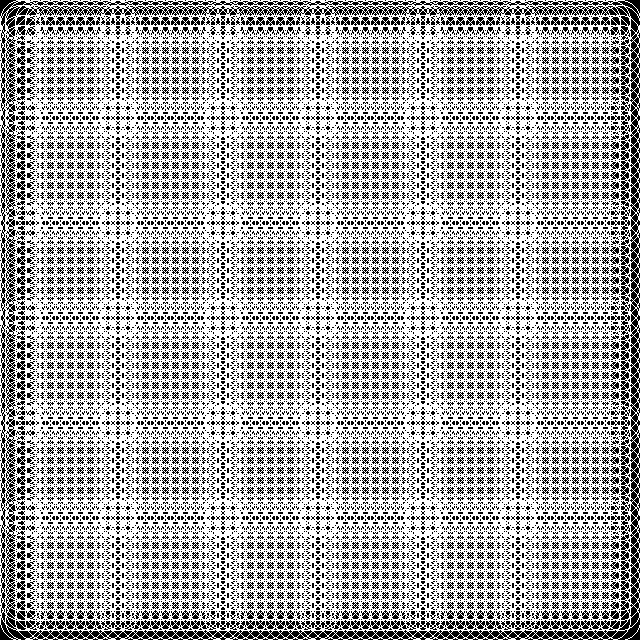

In [18]:
%%time
sz = config.sample_size
k = 5
retina_map_image = Image.new('RGBA', (sz * k, sz * k), color='black')
retina_map_draw = ImageDraw.Draw(retina_map_image)

for _, row in SENSOR_INSTANCES_INFO.iterrows():
    center_x = k * row.x_center
    center_y = k * row.y_center
    radius = k * row.radius
    retina_map_draw.circle((center_x, center_y), radius, width=1, outline=200)

retina_map_image

In [19]:
SENSOR_PATCH_COORDS = []

for row in SENSOR_INSTANCES_INFO.itertuples():
    x_offset = row.x_offset
    y_offset = row.y_offset
    size = row.size

    for i in range(size):
        y = (y_offset + i) * config.sample_size
        stride_coords = np.arange(y + x_offset, y + x_offset + size)
        SENSOR_PATCH_COORDS.append(stride_coords)

SENSOR_PATCH_COORDS = np.array(SENSOR_PATCH_COORDS)

In [20]:
def get_image_patches_for_sensor_instances(images_matrix):
    assert images_matrix.ndim == 2, images_matrix.ndim
    assert images_matrix.shape[1] == config.sample_size ** 2, images_matrix.shape[1]
    images_count = images_matrix.shape[0]
    # Result is 3d-tensor: 1 dim - image, 2 dim - patch no, 3 dim - patch itself (pixels)
    return np.take(images_matrix, SENSOR_PATCH_COORDS, axis=1).reshape(images_count, -1, SENSOR_RECEPTIVE_FIELD_SQUARE)

# sequence_images

In [21]:
# Returns matrix of sense_vectors (one row = sense_vector for each image in images_matrix)
# Each elem in sense_vector describes sensor state of each sensor instance (-1 if sensor instance is not activated)
def sense_images(images_matrix):
    MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
    MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
    MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)
    MINIMAL_PLUS_MINUS_DISTR_REL_DIFF = 0.9
    
    assert images_matrix.ndim == 2
    images_count = images_matrix.shape[0]
    images_patches = get_image_patches_for_sensor_instances(images_matrix) # array of matrices: image no -> matrix with patches as row vectors
    
    mean_luminiscene_in_patches = images_patches.mean(axis=2) # matrix where each row = avg of luminisnece in each patch of an image
    mean_images_patches = images_patches.reshape(-1, SENSOR_RECEPTIVE_FIELD_SQUARE).T - mean_luminiscene_in_patches.ravel()
    mean_images_patches = mean_images_patches.T.reshape(images_count, -1, SENSOR_RECEPTIVE_FIELD_SQUARE).transpose(0, 2, 1)
    # mean_images_patches is an array of matrices: image no -> matrix with mean-centered patches as column vectors
    
    images_patches = images_patches.transpose(0, 2, 1) # array of matrices: image no -> matrix with patches as column vectors
    assert images_patches.shape == mean_images_patches.shape
    
    abs_illum_level_pos = (SENSOR_STATES_POS @ images_patches).transpose(0, 2, 1)
    abs_illum_level_neg = (SENSOR_STATES_NEG @ images_patches).transpose(0, 2, 1)
    rel_illum_level_pos = (SENSOR_STATES_POS @ xp.where(mean_images_patches > 0, +1, 0)).transpose(0, 2, 1) # for +/- tally
    rel_illum_level_neg = (SENSOR_STATES_NEG @ xp.where(mean_images_patches < 0, -1, 0)).transpose(0, 2, 1)  # for +/- tally
    
    assert abs_illum_level_pos.shape == (images_count, SENSORS_COUNT, SENSOR_STATES_COUNT), abs_illum_level_pos.shape
    assert abs_illum_level_neg.shape == abs_illum_level_pos.shape
    assert rel_illum_level_pos.shape == abs_illum_level_pos.shape
    assert rel_illum_level_neg.shape == abs_illum_level_pos.shape
    
    sense_vectors = []
    # For each patch in image we detect likelihood of activation of sensor in one of its (sensor's) state.
    # If we have some state (say some angle and some sweep), what is condition that given patch corresponds to this state?
    # Of course patch must be somewhat illuminated (regulated by SENSORS_POS) - this is to ensure that we don't get fooled by situation
    # when e.g. negative part is not illuminated (dot prod is 0) while positive part is illuminated very, very week (say dot prod is 5). Looks
    # like this is the reason why we don't hear very low frequencies or don't percieve low light - becase ratio get oversaturaed very quickly.
    # But the key point is that sum of pixels luminiscence can meet averaged criterion only when bright pixels are concentared in area covered by SENSORS_POS
    # and dark pixels are concentrated in area covered by SENSORS_NEG. Otherwise there will disbalance.
    # To detect this condition we can look at distribution of mean-centered patches: +pixels must reside in positive part, -pixels must reside in negative part.
    # To restassure that +/- distribution of pixels actually corresponds to detectable diff in illumination we also need to compare
    # absolute illumination on positive and negative part
    for ailp_i, ailn_i, rilp_i, riln_i in zip(abs_illum_level_pos, abs_illum_level_neg, rel_illum_level_pos, rel_illum_level_neg): # Per image cycle
        # ailp_i and ailn_i both are matrices N(patches count) x M(count of sensor states)
        shape_save = ailp_i.shape
    
        # MAC {0, 1}
        # Illumination level on positive area must exceed lower threshold (sensor must be somewhat illuminated)
        # abs_illumination_scores = matrix of N(patches count), columns - 0/1 if patch is minimally illuminated according to given sensor's state
        abs_illumination_scores = ailp_i > MINIMAL_ILLUMINATION_ABS_LEVEL * SENSOR_STATE_AREAS_POS
    
        # MAC {0, 1}
        # Illumination level on positive part must distinguishably exceed illumination level of negative part
        ailn_i += 1e-6 # to get rid of possible division by zero errors
        ailp_i = ailp_i / SENSOR_STATE_AREAS_POS
        ailn_i = ailn_i / SENSOR_STATE_AREAS_NEG
        diff_abs_illumination_scores = xp.abs(ailp_i.ravel() / ailn_i.ravel())
        diff_abs_illumination_scores = diff_abs_illumination_scores >= MINIMAL_ILLUMINATION_DIFF_RATIO
        # diff_abs_illumination_scores = matrix of N(patches count), columns - 0/1 if patch is illuminated more on positive part than on negative
        diff_abs_illumination_scores = diff_abs_illumination_scores.reshape(shape_save)
    
        # Score {0, [MINIMAL_PLUS_MINUS_DISTR_REL_DIFF...1]}
        # Tally concentration of +/- pixels on positive/negative side and compare against theirs areas. 
        # For sensors with proper distribution ratio will be around 1 for each of the scores.
        # *concentration_scores = matrix of N(patches count), columns - [0...1] how well pixels in patch are distributed according to given sensor's state
        pluses_concentration_scores = rilp_i / SENSOR_STATE_AREAS_POS
        # assert xp.all((pluses_concentration_scores >= 0) & (pluses_concentration_scores <= 1)) # comment for production (to speed up)
        mask = (pluses_concentration_scores < MINIMAL_PLUS_MINUS_DISTR_REL_DIFF)
        pluses_concentration_scores = xp.where(mask, 0, pluses_concentration_scores)
    
        minuses_concentration_scores = riln_i / SENSOR_STATE_AREAS_NEG
        # assert xp.all((minuses_concentration_scores >= 0) & (minuses_concentration_scores <= 1)) # comment for production (to speed up)
        mask = (minuses_concentration_scores < MINIMAL_PLUS_MINUS_DISTR_REL_DIFF)
        minuses_concentration_scores = xp.where(mask, 0, minuses_concentration_scores)
        
        # sense_matrix = matrix of N(patches count), columns - 0/1 if all three conditions meet for given sensor state
        sense_matrix = (abs_illumination_scores.astype(float) + diff_abs_illumination_scores.astype(float) + pluses_concentration_scores + minuses_concentration_scores)
        min_score = 1 + 1 + (MINIMAL_PLUS_MINUS_DISTR_REL_DIFF * 2)
        sense_vector = xp.where(xp.any(sense_matrix > min_score, axis=1), xp.argmax(sense_matrix, axis=1), -1)
        sense_vectors.append(sense_vector)
    
    return xp.vstack(sense_vectors)

In [22]:
# Returns (altitude_map, df_sensor_instances) for sense_vector
def parse_sense_vector(sense_vector):
    ALTITUDE_EXTEND_BY = 5 # number of new intermediate cells for each side of 2x2 rect, e.g. 3x3 becomes 13x13 if altitude_extend_by is 5
    MAX_LANDING_STEPS = 1000
    MAX_ALTITUDE_THRESHOLD = 2
    
    assert sense_vector.shape[0] == len(SENSOR_INSTANCES_INFO)
    sensor_instance_inds = np.argwhere(sense_vector != -1).ravel()
    sensor_state_inds = np.take(sense_vector, sensor_instance_inds)
    assert sensor_instance_inds.shape[0] == sensor_state_inds.shape[0]
    df_sensor_instances_raw = pd.DataFrame({'sensor_instance_ind': sensor_instance_inds, 'sensor_state_ind': sensor_state_inds})
    df_sensor_instances_raw = df_sensor_instances_raw.merge(SENSOR_STATES_INFO, how='left', left_on='sensor_state_ind', right_index=True)
    df_sensor_instances_raw = df_sensor_instances_raw.merge(SENSOR_INSTANCES_INFO, how='left', left_on='sensor_instance_ind', right_index=True)

    # Lo-resolution altitude map
    altitude_map_lores = np.zeros((config.sample_size, config.sample_size))

    for si in df_sensor_instances_raw.itertuples():
        sensor_state = SENSOR_STATES[si.sensor_state_ind]
        size = si.size
        altitude_map_lores[si.y_offset:si.y_offset + size, si.x_offset:si.x_offset + size] += sensor_state.reshape(size, size)
    
    altitude_map_lores_mask = np.full_like(altitude_map_lores, np.min(altitude_map_lores), dtype='i')
    
    for si in df_sensor_instances_raw.itertuples():
        altitude_map_lores_mask[si.y_offset:si.y_offset + size, si.x_offset:si.x_offset + size] = 0
    
    altitude_map_lores += altitude_map_lores_mask
    altitude_map_lores = altitude_map_lores.astype('i')

    # Enhance lo-resolution altitude map by interpolating. This is to develop low altitude areas which are 
    # hidden beyond patches like [[-4, -5], [3, 4]]
    altitude_lores_to_hires_translate_factor = (ALTITUDE_EXTEND_BY + 1)
    altitude_map_hires_size = (config.sample_size - 1) * altitude_lores_to_hires_translate_factor + 1
    altitude_map_hires = np.zeros((altitude_map_hires_size, altitude_map_hires_size), dtype='f')
    patch_hires_shape = (2 + ALTITUDE_EXTEND_BY, 2 + ALTITUDE_EXTEND_BY)
    ii, jj = np.mgrid[0:patch_hires_shape[0], 0:patch_hires_shape[1]]
    patch_hires_indices = np.array(list(zip(ii.ravel(), jj.ravel())))
    
    for i in range(altitude_map_lores.shape[0] - 1):
        for j in range(altitude_map_lores.shape[1] - 1):
            patch = altitude_map_lores[i:i+2, j:j+2].astype(float)
    
            if patch[0,0] == patch[0,1] and patch[0,1] == patch[1,0] and patch[1,0] == patch[1,1]:
                patch_hires = patch[0,0]
            else:
                interp = RegularGridInterpolator(([0, patch_hires_shape[0] - 1], [0, patch_hires_shape[1] - 1]), patch)
                patch_hires = interp(patch_hires_indices).reshape(patch_hires_shape)
                
            i_hires = i * altitude_lores_to_hires_translate_factor
            j_hires = j * altitude_lores_to_hires_translate_factor
            altitude_map_hires[i_hires:i_hires+patch_hires_shape[0], j_hires:j_hires+patch_hires_shape[1]] = patch_hires

    # Reposition sensor instances so they occur in a valley with low absolute altitude. Some of the sensor instances will get discarded
    landed_centers = defaultdict(list)

    for si in df_sensor_instances_raw.itertuples():
        x_center_land = si.x_center * altitude_lores_to_hires_translate_factor
        y_center_land = si.y_center * altitude_lores_to_hires_translate_factor
        altitude = altitude_map_hires[y_center_land, x_center_land]
    
        if np.abs(altitude) > 1:
            travel_point = complex(x_center_land, y_center_land)
            direction = -1 if altitude < 0 else +1
            
            for i in range(MAX_LANDING_STEPS):
                travel_point += direction * si.normal_vec
                new_x_center_land = np.round(travel_point.real, decimals=0).astype(int)
                new_y_center_land = np.round(travel_point.imag, decimals=0).astype(int)
                new_altitude = np.abs(altitude_map_hires[new_y_center_land, new_x_center_land])
    
                if new_altitude <= altitude:
                    altitude = new_altitude
                    x_center_land = new_x_center_land
                    y_center_land = new_y_center_land
                else:
                    break
            else:
                assert False
    
        landed_centers['x_center_new'].append(x_center_land)
        landed_centers['y_center_new'].append(y_center_land)
        landed_centers['x_center_orig'].append(int(x_center_land / altitude_lores_to_hires_translate_factor))
        landed_centers['y_center_orig'].append(int(y_center_land / altitude_lores_to_hires_translate_factor))
        landed_centers['altitude_new'].append(altitude)
    
    df_sensor_instances = df_sensor_instances_raw.copy()
    
    for col_name, values in landed_centers.items():
        df_sensor_instances[col_name] = values
    
    df_sensor_instances.drop(['x_center', 'y_center', 'x_offset', 'y_offset', 'bounds_rect', 'normal_vec', 'sweep1_vec', 'sweep2_vec', 'size'], axis=1, inplace=True)
    df_sensor_instances.rename({'x_center_new': 'x_center', 'y_center_new': 'y_center', 'altitude_new': 'altitude'}, axis=1, inplace=True, errors='raise')
    df_sensor_instances = df_sensor_instances.loc[np.abs(df_sensor_instances.altitude) < MAX_ALTITUDE_THRESHOLD]
    df_sensor_instances['x'] = df_sensor_instances.x_center.astype(str) + ',' + df_sensor_instances.y_center.astype(str)
    df_sensor_instances.drop_duplicates(subset=['x'], inplace=True)
    return (altitude_map_hires, df_sensor_instances)

In [23]:
def discover_raw_sequences(sensor_instance_ind_dict, altitude_map):
    sensor_instance_map = dict(map(lambda si: ((si.y_center, si.x_center), si), sensor_instance_ind_dict.values()))
    unsorted_sensor_instance_inds = set(map(lambda si: si.Index, sensor_instance_ind_dict.values()))
    raw_sequences = {} # start_sensor_inst_index -> sensor_inst_chains
    
    while unsorted_sensor_instance_inds:
        # choose random sensor instance to start from
        start_sensor_inst_index = unsorted_sensor_instance_inds.pop()
        start_sensor_inst = sensor_instance_ind_dict[start_sensor_inst_index]
        
        wave_front_que = deque([(int(start_sensor_inst.y_center), int(start_sensor_inst.x_center))])
        wave_front_map = np.full_like(altitude_map, -1, dtype='i')
        wave_front_map[wave_front_que[0]] = start_sensor_inst.Index
        wave_front_touched = set([wave_front_que[0]])
        
        sensor_inst_chains = {} # key - last element in chain of sensor instances, value - chain itself
        
        # LOG(f'Starting countour from {start_sensor_inst_index} (of {len(unsorted_sensor_instance_inds)})')
        
        while wave_front_que:
            # Visit point on top of the wave_front
            wave_front_point = wave_front_que.popleft()
            wave_front_sensor_inst_ind = wave_front_map[wave_front_point]
            wave_front_map[wave_front_point] = -1
            assert wave_front_sensor_inst_ind > -1
            # LOG(f'Visiting {wave_front_point} (si={wave_front_sensor_inst_ind}) (of {len(wave_front_que)})')
        
            si = sensor_instance_map.get(wave_front_point, None)
        
            if not si is None and si.Index != wave_front_sensor_inst_ind:
                # New sensor instance discovered! Link with the previous one, ...
                sensor_inst_chain = sensor_inst_chains.pop(wave_front_sensor_inst_ind, [wave_front_sensor_inst_ind])
                sensor_inst_chain.append(si.Index)
                assert not si.Index in sensor_inst_chains, f'{si.Index} in sensor_inst_chains'
                sensor_inst_chains[si.Index] = sensor_inst_chain
                
                # LOG(f'New si encountered: {si.Index}, linked after {wave_front_sensor_inst_ind}')
                wave_front_sensor_inst_ind = si.Index
                # ... and adjust adjacent wave front points to account for new sensor instance
                # (adjacency criteria enables coexisting of separate (disjoint) wave fronts on a map)
                adjust_stack = [wave_front_point]
                adjust_touched = set([wave_front_point])
        
                while adjust_stack:
                    adjust_point = adjust_stack.pop()
        
                    for rel_ij in [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]:
                        ij = int(adjust_point[0] + rel_ij[0]), int(adjust_point[1] + rel_ij[1])
                
                        if ij[0] < 0 or ij[1] < 0 or ij[0] >= wave_front_map.shape[0] or ij[1] >= wave_front_map.shape[1]:
                            continue
                        elif wave_front_map[ij] == -1:
                            continue
                        elif ij in adjust_touched:
                            continue
        
                        # LOG(f'Adjusting {ij} (si={wave_front_map[ij]}) to si={si.Index}')
                        wave_front_map[ij] = si.Index
                        adjust_stack.append(ij)
                        adjust_touched.add(ij)
        
            # Plan further spread of the wave front
            for rel_ij in [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]:
                ij = int(wave_front_point[0] + rel_ij[0]), int(wave_front_point[1] + rel_ij[1])
                # LOG(f'... spread, checking coord {rel_ij} {ij}')
        
                if ij[0] < 0 or ij[1] < 0 or ij[0] >= altitude_map.shape[0] or ij[1] >= altitude_map.shape[1]:
                    # LOG(f'... spread, {ij} out of boundaries')
                    continue
                elif np.abs(altitude_map[ij]) >= 2: # coord_ij falls out of valley
                    # LOG(f'... spread, {ij} has bad altitude {altitude_map[ij]}')
                    continue
                elif ij in wave_front_touched:
                    # LOG(f'... spread, {ij} already touched ({len(wave_front_touched)})')
                    continue
        
                wave_front_touched.add(ij)
                wave_front_que.append(ij)
                wave_front_map[ij] = wave_front_sensor_inst_ind
                # LOG(f'... new wave front point {wave_front_que[-1]} (si={wave_front_sensor_inst_ind})')
    
        raw_sequences[start_sensor_inst_index] = sensor_inst_chains
        # Collect all sensor instances encountered during this run and account them as sorted
        sorted_sensor_instance_inds = set(itertools.chain.from_iterable(sensor_inst_chains.values()))
        unsorted_sensor_instance_inds -= sorted_sensor_instance_inds

    return raw_sequences